In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os
import cv2
import math
import pandas as pd
import pickle as pk
from matplotlib.pyplot import figure

In [24]:
#DIR = os.path.join(HOME, 'programming', 'dk39')
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK43'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
OUTPUT = os.path.join(DIR, 'preps', 'CH1', 'cleaned')
MASKED = os.path.join(DIR, 'preps', 'masked')
files = sorted(os.listdir(INPUT))

In [78]:
def place_image(img, max_width, max_height):
    zmidr = max_height // 2
    zmidc = max_width // 2
    startr = zmidr - (img.shape[0] // 2)
    endr = startr + img.shape[0]
    startc = zmidc - (img.shape[1] // 2)
    endc = startc + img.shape[1]
    new_img = np.zeros([max_height, max_width]) 
    
    try:
        new_img[startr:endr,startc:endc] = img
    except:
        print('could not create new img', file, img.shape)
        
    return new_img.astype('uint8')


def im_type(src):
    print('dtype=',src.dtype,'shape=',src.shape)

def disp(image):
    figure(figsize=[30,8])
    im_type(image)
    imshow(image.T,'gray');


    
def find_thresholdYYY(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0,0,0,0))
    n,bins,patches=ax.hist(src.flatten(),160);
    del ax, fig
    min_point=np.argmin(n[:5])
    thresh=min_point*64000/160+1000
    return min_point, thresh

def find_main_blob(stats,image):
    height,width=image.shape
    df=pd.DataFrame(stats)
    df.columns=['Left','Top','Width','Height','Area']
    df['blob_label']=df.index
    df=df.sort_values(by='Area',ascending=False)

    for row in df.iterrows():
        Left=row[1]['Left']
        Top=row[1]['Top']
        Width=row[1]['Width']
        Height=row[1]['Height']
        corners= int(Left==0)+int(Top==0)+int(Width==width)+int(Height==height)
        if corners<=2:
            return row


def scale_and_mask(src,mask,epsilon=0.01):
    vals=np.array(sorted(src[mask>10]))
    ind=int(len(vals)*(1-epsilon))
    _max=vals[ind]
    # print('thr=%d, index=%d'%(vals[ind],index))
    _range=2**16-1
    scaled=src*(45000./_max)
    scaled[scaled>_range]=_range
    scaled=scaled*(mask>10)
    return scaled,_max


def find_thresholdYYY(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0,0,0,0))
    n,bins,patches=ax.hist(src.flatten(),160);
    del ax, fig
    min_point=np.argmin(n[:5])
    thresh=min_point*64000/160+1000
    return min_point, thresh

def get_last_2d(data):
    if data.ndim <= 2:
        return data
    m,n = data.shape[-2:]
    return data.flat[:m*n].reshape(m,n)


strip_max=70; strip_min=5   # the range of width for the stripe
def remove_strip(src):
    projection=np.sum(src,axis=0)/10000.
    diff=projection[1:]-projection[:-1]
    loc,=np.nonzero(diff[-strip_max:-strip_min]>50)
    mval=np.max(diff[-strip_max:-strip_min])
    #print('  ',mval,i,end=' ')
    no_strip=np.copy(src)
    fe = 0
    if loc.shape[0]>0:
        loc=np.min(loc)
        from_end=strip_max-loc           
        #print(from_end,diff[-from_end-2:-from_end+2])
        fe = -from_end-2
        no_strip[:,-from_end-2:]=0 # mask the strip
    return no_strip, fe

def find_threshold(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0, 0, 0, 0))
    n, bins, patches = ax.hist(src.flatten(), 360);
    del ax, fig
    min_point = np.argmin(n[:5])
    min_point = int(min(2, min_point))
    thresh = (min_point * 64000 / 360) + 100
    return min_point, thresh



def fillmaskXXX(img):
    # Threshold.
    # Set values equal to or above 220 to 0.
    # Set values below 220 to 255.
    th, im_th = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY_INV);
    # Copy the thresholded image.
    im_floodfill = im_th.copy()
    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);    
    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    
    return im_floodfill_inv


def fillmask(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #return cv2.fillPoly(mask, contours, color=(255,255,0))
    cv2.drawContours(mask, contours, -1, (0,255,0), 3)
    return mask

In [4]:
max_width = 1050
max_height = 1750
#max_width = 50100
#max_height = 34000
#1048x1738
#988x1624
#709x594
max_width = 1050
max_height = 1750

In [5]:
print(max_width, max_height, len(files))

1050 1750 392


In [6]:
# what is wrong with 351???
badis = [43,77,104,107,123,240,241,242,243,244,245,249,250,251,252,253,300,326,351,362,363,364]
bads = [files[i] for i in badis]

In [7]:
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

In [97]:
def fillhole(input_image):
    '''
    input gray binary image  get the filled image by floodfill method
    Note: only holes surrounded in the connected regions will be filled.
    :param input_image:
    :return:
    '''
    im_flood_fill = input_image.copy()
    h, w = input_image.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    im_flood_fill = im_flood_fill.astype("uint8")
    cv2.floodFill(im_flood_fill, mask, (0, 0), 255)
    im_flood_fill_inv = cv2.bitwise_not(im_flood_fill)
    img_out = input_image | im_flood_fill_inv
    return img_out

# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
titles = []
results=[]
strips = []
norms = []
masks = []
for i, file in enumerate(tqdm(files)):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    img_inputs.append(img)
    file_inputs.append(file)
    
    #strip_src = linnorm(img, 2**14)
    #norms.append(strip_src)
    #strip_src = clahe.apply(src)
    no_strip, fe = remove_strip(img)
    #src = crop_bar(src)
    min_point, threshold = find_threshold(no_strip)
    #print(min_point, threshold)
    #threshold = max(200, threshold)
    #threshold = 400
    ret, threshed = cv2.threshold(no_strip,threshold,255,cv2.THRESH_BINARY)
    threshed=np.uint8(threshed)
    ###### Find connected elements
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4
    output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    # Find the blob that corresponds to the section.
    row=find_main_blob(stats,img)
    blob_label=row[1]['blob_label']
    #extract the blob
    blob=np.uint8(labels==blob_label)*255
    #Perform morphological closing
    kernel10 = np.ones((10,10),np.uint8)
    closing = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
    del blob
    if fe != 0:
        img[:,fe:]=0 # mask the strip
    # scale and mask
    try:
        scaled,_max=scale_and_mask(img,closing)
    except:
        print(min_point, threshold, file)
    #masks.append(closing)
    #img = place_image(img, max_width, max_height)
    #####titles.append((min_point, threshold))
    #####img_outputs.append(closing)
    #flooded = fillhole(closing)
    #masks.append(flooded)

    
    #outpath = os.path.join(OUTPUT, file)    
    #cv2.imwrite(outpath, scaled.astype('uint16'))
    outpath = os.path.join(MASKED, file)    
    cv2.imwrite(outpath, closing.astype('uint8'))
print('Finished')


100%|██████████| 392/392 [03:05<00:00,  2.11it/s]

Finished


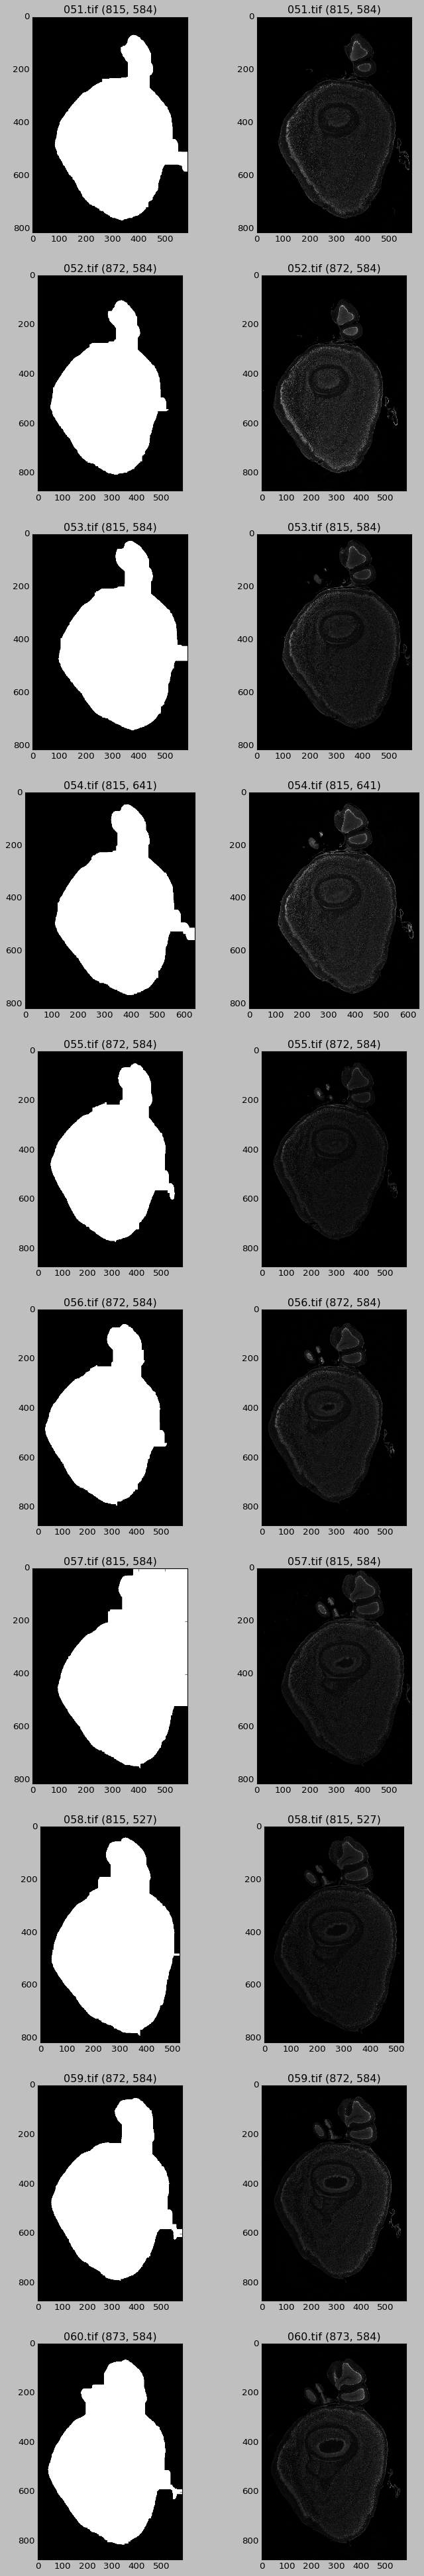

In [106]:
start, finish = (50,60)
#displays = masks[start:finish]
ins = masks[start:finish]
outs = img_inputs[start:finish]
names = file_inputs[start:finish]
tdisplays = titles[start:finish]
fig, ax = plt.subplots(nrows=len(names), ncols=2, sharex=False)
plt.style.use('classic')
i = 0
for old, new, name, tdisplay in zip(ins, outs, names, tdisplays):
    ax[i,0].set_title('{} {}'.format(name, str(old.shape)))
    ax[i,0].imshow(old, cmap='gray')

    ax[i,1].set_title('{} {}'.format(name, str(old.shape)))
    ax[i,1].imshow(new, cmap='gray')
    i += 1
# swap the 10 and the six below if the images are wider than height
fig.set_size_inches(np.array([10, 6 * len(names)]), forward=True)
plt.show()